In [33]:
import soundfile as sf
import numpy as np
import librosa
import glob
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [8, 4]

In [34]:
df = pd.read_csv('./Data/filtered_data_labeled.tsv', sep='\t')
df.drop(columns=['client_id'], inplace=True)
display(df.head())

,path,sentence,up_votes,down_votes,age,gender,accent,label
0,common_voice_en_19687170.mp3,He associated with the Formists.,2,1,fifties,female,us,3
1,common_voice_en_19687171.mp3,"The ""ultra accelerator"" injection gives Derric...",2,1,fifties,female,us,3
2,common_voice_en_19687172.mp3,"Despite running as a joke, candidates have won...",2,0,fifties,female,us,3
3,common_voice_en_19687173.mp3,Stoner also guest-starred in the television dr...,2,0,fifties,female,us,3
4,common_voice_en_19687174.mp3,Rainelle was named for the Raine family.,2,0,fifties,female,us,3


In [35]:
def eda(df, row_limit=5, list_elements_limit=10):
    print('Info: There are {} rows and {} columns in the dataset'.format(df.shape[0], df.shape[1]))
    print('\n')

    dtypes_df = pd.DataFrame(df.dtypes).reset_index().rename(columns={0:'dtype', 'index':'column_name'})
    cat_df = dtypes_df[dtypes_df['dtype']=='object']
    num_df = dtypes_df[dtypes_df['dtype']!='object']

    print('There are {} categorical columns'.format(len(cat_df)))
    print('There are {} numerical columns'.format(len(num_df)))
    print('\n')
    if list_elements_limit >= len(cat_df):
        print('The categorical columns are: {}'.format(list(cat_df['column_name'])))
    else:
        print('The categorical columns are: {}'.format(list(cat_df['column_name'])[:list_elements_limit]))
    
    if list_elements_limit >= len(num_df):
        print('The numerical columns are: {}'.format(list(num_df['column_name'])))
    else:
        print('The numerical columns are: {}'.format(list(num_df['column_name'])[:list_elements_limit]))

    display(dtypes_df.head(row_limit))

    print('\n')

    desc_df_cat = df[cat_df['column_name']].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_cat.head(row_limit))

    print('\n')
    print('Null Values in the dataset')
    print(df.isnull().sum())

    return

In [36]:
eda(df, row_limit=10, list_elements_limit=10)

Info: There are 209791 rows and 8 columns in the dataset


There are 5 categorical columns
There are 3 numerical columns


The categorical columns are: ['path', 'sentence', 'age', 'gender', 'accent']
The numerical columns are: ['up_votes', 'down_votes', 'label']


,column_name,dtype
0,path,object
1,sentence,object
2,up_votes,int64
3,down_votes,int64
4,age,object
5,gender,object
6,accent,object
7,label,int64


,column_name,count,unique,top,freq
0,path,209791,209791,common_voice_en_19499081.mp3,1
1,sentence,209791,99541,"If you start your emails with ""Greetings"" let ...",48
2,age,209791,2,twenties,168343
3,gender,209791,2,male,165983
4,accent,153547,17,us,75940




Null Values in the dataset
path              0
sentence          0
up_votes          0
down_votes        0
age               0
gender            0
accent        56244
label             0
dtype: int64


In [37]:
LE_age = LabelEncoder()
df['age'] = LE_age.fit_transform(df['age'])

LE_gender = LabelEncoder()
df['gender'] = LE_gender.fit_transform(df['gender'])

In [38]:
print(LE_age.classes_)

['fifties' 'twenties']


In [39]:
print(LE_gender.classes_)

['female' 'male']


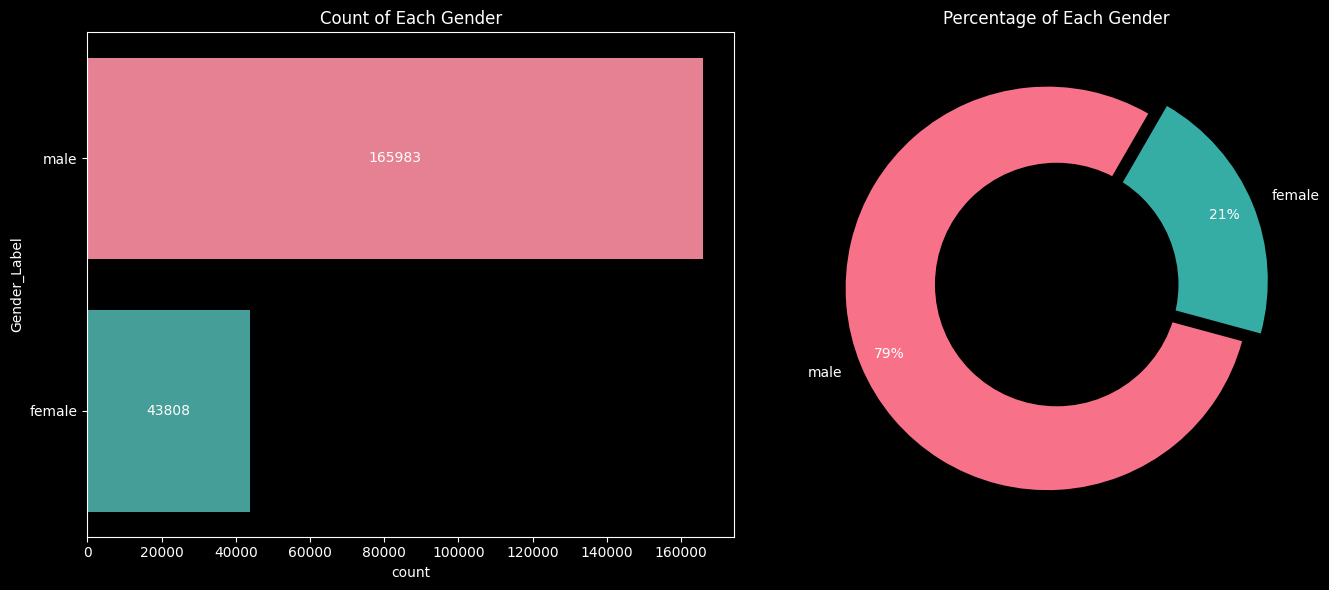

In [40]:
df['Gender_Label'] = LE_gender.inverse_transform(df['gender'])

gender_counts = df['Gender_Label'].value_counts()
gender_labels = gender_counts.index
gender_sizes = gender_counts.values

gender_colors = sns.color_palette("husl", n_colors=len(gender_counts))
gender_color_map = dict(zip(gender_labels, gender_colors))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(y=df['Gender_Label'], order=gender_labels, palette=gender_color_map, ax=axes[0])
axes[0].set_title("Count of Each Gender", color='white')
axes[0].tick_params(axis='both', colors='white')
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', label_type='center', color='white')

explode = [0.05] * len(gender_sizes)
axes[1].pie(
    gender_sizes,
    labels=gender_labels,
    colors=[gender_color_map[label] for label in gender_labels],
    explode=explode,
    startangle=60,
    autopct='%1.0f%%',
    pctdistance=0.85,
    textprops={'color': 'white'}
)
axes[1].add_artist(plt.Circle((0, 0), 0.6, color='black'))
axes[1].set_title("Percentage of Each Gender", color='white')

plt.tight_layout()
plt.show()


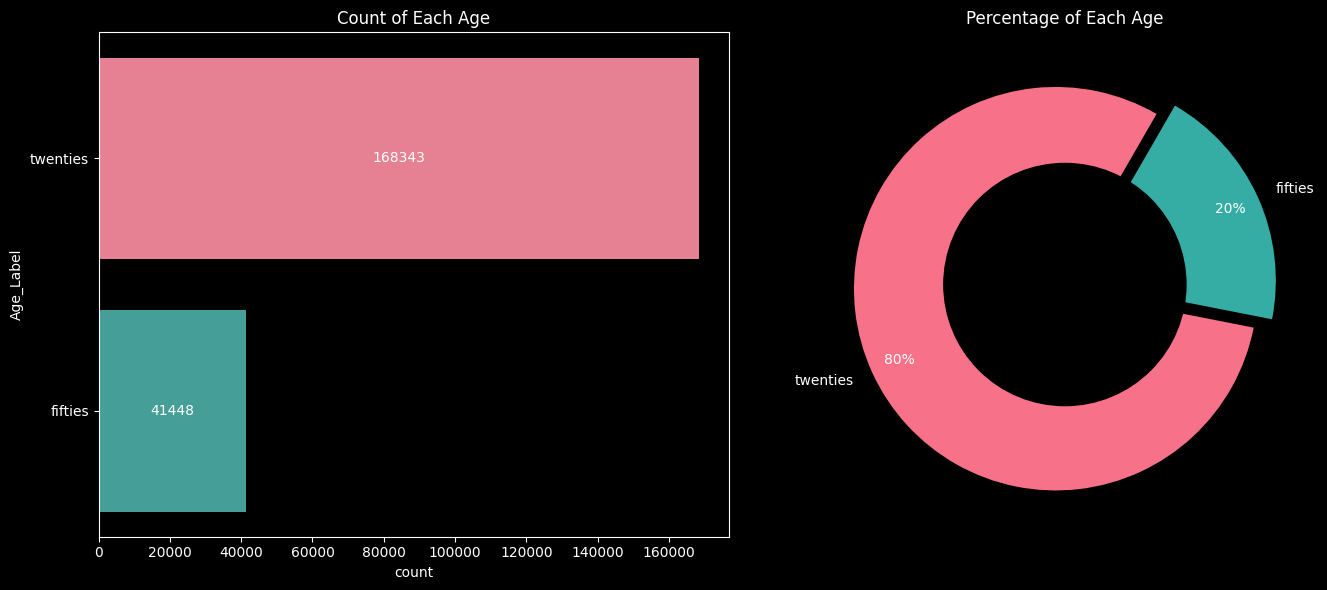

In [41]:
df['Age_Label'] = LE_age.inverse_transform(df['age'])

age_counts = df['Age_Label'].value_counts()
age_labels = age_counts.index
age_sizes = age_counts.values

age_colors = sns.color_palette("husl", n_colors=len(age_counts))
age_color_map = dict(zip(age_labels, age_colors))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(y=df['Age_Label'], order=age_labels, palette=age_color_map, ax=axes[0])
axes[0].set_title("Count of Each Age", color='white')
axes[0].tick_params(axis='both', colors='white')
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', label_type='center', color='white')

explode = [0.05] * len(age_sizes)
axes[1].pie(
    age_sizes,
    labels=age_labels,
    colors=[age_color_map[label] for label in age_labels],
    explode=explode,
    startangle=60,
    autopct='%1.0f%%',
    pctdistance=0.85,
    textprops={'color': 'white'}
)
axes[1].add_artist(plt.Circle((0, 0), 0.6, color='black'))
axes[1].set_title("Percentage of Each Age", color='white')

plt.tight_layout()
plt.show()


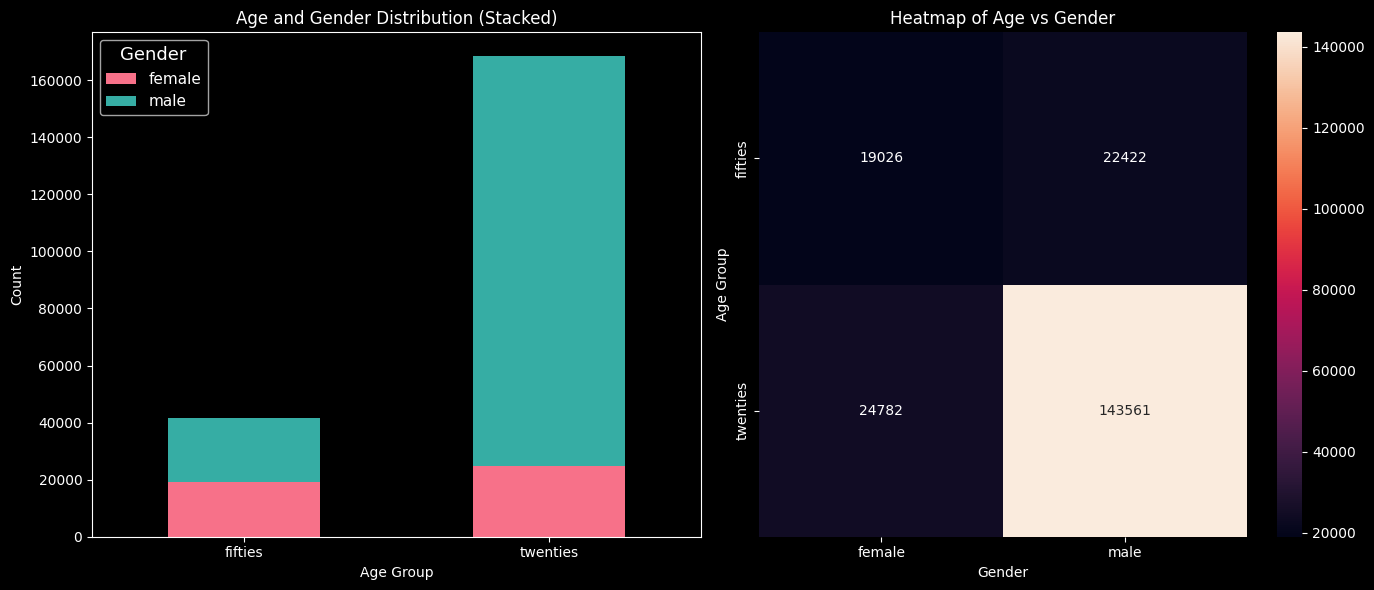

In [42]:
df['Age_Label'] = LE_age.inverse_transform(df['age'])
df['Gender_Label'] = LE_gender.inverse_transform(df['gender'])

age_gender_counts = df.groupby(['Age_Label', 'Gender_Label']).size().unstack().fillna(0)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

age_gender_counts.plot(
    kind='bar',
    stacked=True,
    color=sns.color_palette('husl', 2),
    ax=axes[0]
)
axes[0].set_title("Age and Gender Distribution (Stacked)", color='white')
axes[0].set_xlabel("Age Group", color='white')
axes[0].set_ylabel("Count", color='white')
axes[0].tick_params(axis='x', rotation=0, colors='white')
axes[0].tick_params(axis='y', colors='white')
axes[0].legend(title='Gender', facecolor='black', labelcolor='white', title_fontsize='13', fontsize='11')

sns.heatmap(age_gender_counts, annot=True, fmt='d', ax=axes[1])
axes[1].set_title("Heatmap of Age vs Gender", color='white')
axes[1].set_xlabel("Gender", color='white')
axes[1].set_ylabel("Age Group", color='white')
axes[1].tick_params(axis='x', colors='white')
axes[1].tick_params(axis='y', colors='white')

plt.tight_layout()
plt.show()